In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
import matplotlib.colors as mcolors
import seaborn as sns

import utils as ut

# Data loading

In [2]:
soma_root = Path('./data/DE_results_paper/Somalogic_plasma')  # publication data

In [3]:
# Define the file pattern
file_pattern = 'Collagen_cluster_{i}.gender-body_mass_index.Collagen cluster {i}.csv'

# Dictionary to store results
soma_results = {}

for i in range(7):  # Assuming clusters 0 through 6
    cluster_label = f'C{i}'  # Label for the cluster
    file_name = file_pattern.format(i=i)
    file_path = Path(file_name)
    soma_results[cluster_label] = pd.read_csv(soma_root.joinpath(file_path))

bridging_in_file = Path('bridging_fibrosis.gender-body_mass_index.yes_vs_no.csv')
cpa_in_file = Path('Collagen_PA.gender-body_mass_index.Collagen PA.csv')

soma_results['CPA'] = pd.read_csv(soma_root.joinpath(cpa_in_file))
soma_results['F3-F4'] = pd.read_csv(soma_root.joinpath(bridging_in_file))

soma_results, trimmed_proteins = ut.trim_gene_sets(soma_results)
print(f'Trimmed proteins: {trimmed_proteins}')
total_proteins = ut.validate_and_count_genes(soma_results)
print(f"Total number of unique proteins: {total_proteins}")

All genes (Ensembl IDs): 7215
Common genes (Ensembl IDs): 7215
Trimmed genes (Ensembl IDs): 0
Trimmed gene names: set()
Trimmed proteins: []
Total number of unique proteins: 7215


### Un-logging F3-F4 Effect Size to match scale with others

In [4]:
soma_results['F3-F4']['effect_size'] = soma_results['F3-F4']['effect_size'].apply(
    lambda x: -2 ** abs(x) if x < 0 else 2 ** x
)

### Output paths

In [5]:
output_dir = Path('./fibrosis_soma_interpretation')
proteins_output_dir = Path('./fibrosis_soma_interpretation/significant_proteins')
plots_output_dir = Path('./fibrosis_soma_interpretation/plots')

for d in (output_dir, proteins_output_dir, plots_output_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

### Annotation colours

In [6]:
metric_colours = {
    'C0': '#ffffff',
    'C1': '#ffff58',
    'C2': '#ffca00',
    'C3': '#ff5a00',
    'C4': '#ea0000',
    'C5': '#7a0000',
    'C6': '#0b0000',
    'CPA': '#708090',
    'F3-F4': '#4A90E2'
}

metric_labels = list(metric_colours.keys())
colour_list = list(metric_colours.values())

# Defining analysis thresholds

In [7]:
effect_size_threshold = 1
p_value_threshold = 0.05

# Identifying significantly DE proteins

In [8]:
significant_protein_sets = {}  # dictionary of sets for set-based plots (Venn, etc.)
significant_proteins = {}  # dictionary of dataframes for further analysis

# Loop through clusters using labeled keys
for cluster_label, df in soma_results.items():
    extracted_protein_sets, extracted_proteins = ut.extract_significant_genes(
        df,
        effect_size_col='effect_size',
        p_value_col='adj.P.Val',
        gene_name_col='gene_name_biomart',
        effect_size_threshold=effect_size_threshold,
        p_value_threshold=p_value_threshold
    )
    significant_protein_sets[cluster_label] = extracted_protein_sets
    significant_proteins[cluster_label] = extracted_proteins

# Access individual significant proteins if needed
c0_significant_proteins = significant_proteins['C0']
c1_significant_proteins = significant_proteins['C1']

In [9]:
for cluster_label, df in significant_proteins.items():
    output_path = proteins_output_dir / f"significant_proteins_{cluster_label}.csv"
    df.to_csv(output_path, index=True)
    print(f"Saved: {output_path}")

Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_C0.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_C1.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_C2.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_C3.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_C4.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_C5.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_C6.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_CPA.csv
Saved: fibrosis_soma_interpretation/significant_proteins/significant_proteins_F3-F4.csv


In [10]:
# Check the size of each protein set
for cluster_label in significant_protein_sets.keys():
    print(f"Number of proteins in {cluster_label}:", len(significant_protein_sets[cluster_label]))

print('\n')

# Check the overlap between neighboring protein sets
cluster_labels = list(significant_protein_sets.keys())  # Get the list of cluster labels
for i in range(len(cluster_labels) - 1):  # Compare each cluster with the next one
    overlap = len(significant_protein_sets[cluster_labels[i]] & significant_protein_sets[cluster_labels[i + 1]])
    print(f"Overlap between {cluster_labels[i]} and {cluster_labels[i + 1]}:", overlap)

# Check the overlap between the first and last cluster
if len(cluster_labels) > 1:  # Ensure there is more than one cluster to compare
    first_last_overlap = len(significant_protein_sets[cluster_labels[0]] & significant_protein_sets[cluster_labels[-1]])
    print(f"Overlap between {cluster_labels[0]} and {cluster_labels[-1]}:", first_last_overlap)


Number of proteins in C0: 18
Number of proteins in C1: 0
Number of proteins in C2: 0
Number of proteins in C3: 10
Number of proteins in C4: 226
Number of proteins in C5: 552
Number of proteins in C6: 68
Number of proteins in CPA: 61
Number of proteins in F3-F4: 598


Overlap between C0 and C1: 0
Overlap between C1 and C2: 0
Overlap between C2 and C3: 0
Overlap between C3 and C4: 0
Overlap between C4 and C5: 208
Overlap between C5 and C6: 36
Overlap between C6 and CPA: 1
Overlap between CPA and F3-F4: 6
Overlap between C0 and F3-F4: 1


In [11]:
protein_metadata = ut.extract_gene_metadata(significant_proteins)  #df mapping Ensembl IDs to gene names

### Total number of unique DE genes

In [12]:
ut.count_unique_genes(significant_proteins)

963

In [13]:
ut.compare_deg_counts(significant_proteins, total_proteins)

Global Chi-squared p-value: 0.0


,C0,C3,C4,C5,C6,CPA,F3-F4
C0,NaN,1.854496e-01,1.363189e-45,1.044248e-124,2.092256e-08,9.454353e-07,6.936596e-139
C3,1.854496e-01,NaN,3.904230e-50,9.622163e-130,1.422993e-11,1.050166e-09,5.784982e-144
C4,1.363189e-45,3.904230e-50,NaN,1.632512e-34,4.459663e-23,5.190725e-26,4.321633e-44
C5,1.044248e-124,9.622163e-130,1.632512e-34,NaN,6.319610e-95,2.020524e-99,8.057153e-02
C6,2.092256e-08,1.422993e-11,4.459663e-23,6.319610e-95,NaN,4.890793e-01,1.747880e-108
CPA,9.454353e-07,1.050166e-09,5.190725e-26,2.020524e-99,4.890793e-01,NaN,4.081294e-113
F3-F4,6.936596e-139,5.784982e-144,4.321633e-44,8.057153e-02,1.747880e-108,4.081294e-113,NaN


### C4, C5, C6, CPA, F3-F4

In [14]:
fibrosis_marker_protein_sets = dict(list(significant_protein_sets.items())[4:])

# Create a new dictionary excluding specific clusters
fibrosis_marker_proteins = {
    cluster: df.copy() for cluster, df in significant_proteins.items() if cluster not in ['C0', 'C1', 'C2', 'C3']
}

# General up/downregulation trend

Figure saved as fibrosis_soma_interpretation/plots/Proteomic_Signal_by_Metric.png


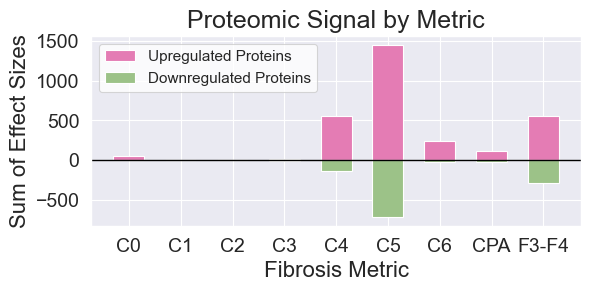

In [15]:
ut.visualize_general_trend(soma_results, effect_size_threshold, p_value_threshold, plots_output_dir, input_type='Proteins')

In [16]:
ut.determine_regulation_trend(significant_proteins)

,Total Genes,Upregulated,Downregulated,Upregulated Ratio,Downregulated Ratio,Mean Upregulated Effect Size,Mean Downregulated Effect Size,Weighted Upregulated Score,Weighted Downregulated Score,Combined Weighted Score,Trend
C0,18,17,1,0.944444,0.055556,3.390865,-1.497575,57.644700,-1.497575,56.147125,Upregulated
C1,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,Balanced
C2,0,0,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,Balanced
C3,10,8,2,0.800000,0.200000,1.958721,-2.804024,15.669769,-5.608048,10.061721,Upregulated
C4,248,185,63,0.745968,0.254032,3.017536,-2.078308,558.244068,-130.933408,427.310660,Upregulated
C5,594,342,252,0.575758,0.424242,4.253948,-2.858418,1454.850136,-720.321234,734.528902,Upregulated
C6,72,61,11,0.847222,0.152778,3.927835,-2.569971,239.597941,-28.269684,211.328257,Upregulated
CPA,63,56,7,0.888889,0.111111,2.043211,-2.697807,114.419816,-18.884647,95.535169,Upregulated
F3-F4,654,417,237,0.637615,0.362385,1.339592,-1.191568,558.610063,-282.401630,276.208434,Upregulated


# Venn Diagrams

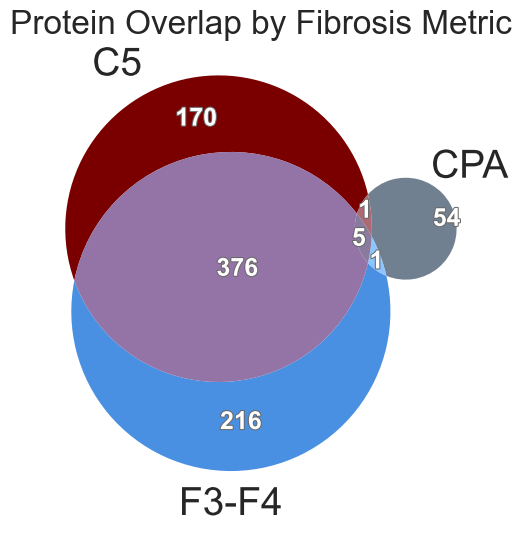

Venn diagram saved as 'fibrosis_soma_interpretation/plots/venn_C5_CPA_F3-F4_ES1_P0.05.png'


In [17]:
selected_labels = ['C5', 'CPA', 'F3-F4']
colour_list = [metric_colours[label] for label in selected_labels if label in metric_colours]
ut.create_cluster_venn(significant_protein_sets, effect_size_threshold, p_value_threshold, selected_labels, plots_output_dir, colour_list, text_color='white', input_type='Proteins')

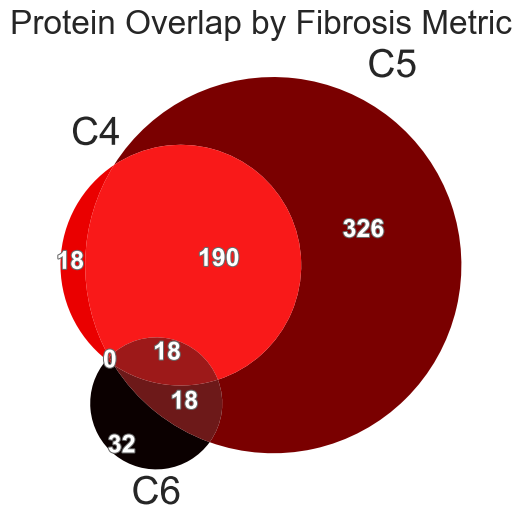

Venn diagram saved as 'fibrosis_soma_interpretation/plots/venn_C4_C5_C6_ES1_P0.05.png'


In [18]:
selected_labels=['C4', 'C5', 'C6']
colour_list = [metric_colours[label] for label in selected_labels if label in metric_colours]
ut.create_cluster_venn(
    significant_protein_sets,
    effect_size_threshold,
    p_value_threshold,
    selected_labels,
    plots_output_dir,
    colors=colour_list,
    text_color='white',  # Makes text inside the circles white
    input_type='Proteins'
)


# Effect size comparisons

Plot saved as fibrosis_soma_interpretation/plots/effect_sizes_C5_CPA_F3-F4.png


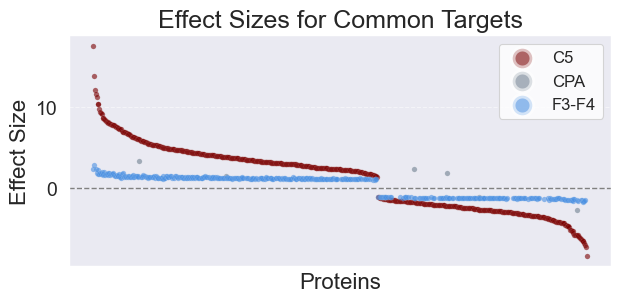

In [19]:
marker_metrics = ut.filter_and_sort_significant_genes(significant_proteins,['C5','CPA', 'F3-F4'], sort_by_metric='C5')
ut.plot_gene_effect_sizes(marker_metrics, metric_colours, plots_output_dir, input_type='Proteins')#, ylims=(-60,55))

Plot saved as fibrosis_soma_interpretation/plots/effect_sizes_C4_C5_C6.png


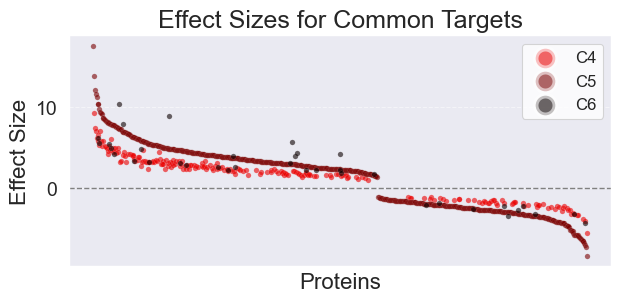

In [20]:
marker_metrics = ut.filter_and_sort_significant_genes(significant_proteins,['C4','C5','C6'], sort_by_metric='C5')
ut.plot_gene_effect_sizes(marker_metrics, metric_colours, plots_output_dir, input_type='Proteins')#, ylims=(-60,55))

 # Metric-metric blood proteomic correlation

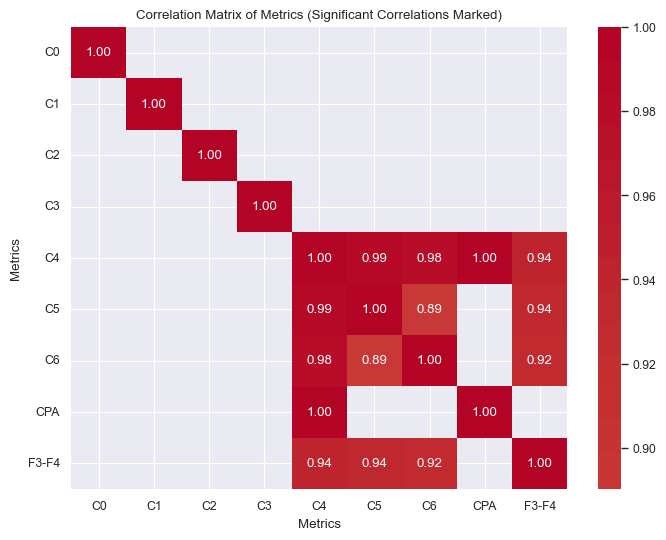

In [21]:
correlation_matrix, p_value_matrix, n_shared_df = ut.compute_metric_correlations(significant_proteins, metric_labels)
ut.plot_metric_correlations(correlation_matrix, p_value_matrix, metric_labels)

# Top proteins table

In [22]:
top_n = 10

# Upregulated

In [23]:
summary_table_upregulated = ut.create_summary_table(fibrosis_marker_proteins, top_n)
summary_table_upregulated = ut.fill_missing_values(summary_table_upregulated, soma_results)
summary_table_upregulated.to_csv(f'{output_dir}/significant_proteins/summary_table_upregulated_top_{top_n}.csv', index=True)

# Downregulated

In [24]:
summary_table_downregulated = ut.create_summary_table(fibrosis_marker_proteins, top_n, downregulated=True)
summary_table_downregulated = ut.fill_missing_values(summary_table_downregulated, soma_results)
summary_table_downregulated.to_csv(f'{output_dir}/significant_proteins/summary_table_downregulated_top_{top_n}.csv', index=True)

### Defining the colourmap

In [25]:
def make_piyg_with_grey_r():
    return mcolors.LinearSegmentedColormap.from_list(
        "PiYG_grey_r",
        [
            (0.0, "#276419"),  # deep green
            (0.5, "#f0f0f0"),  # light grey
            (1.0, "#8e0152")   # deep pink
        ]
    )

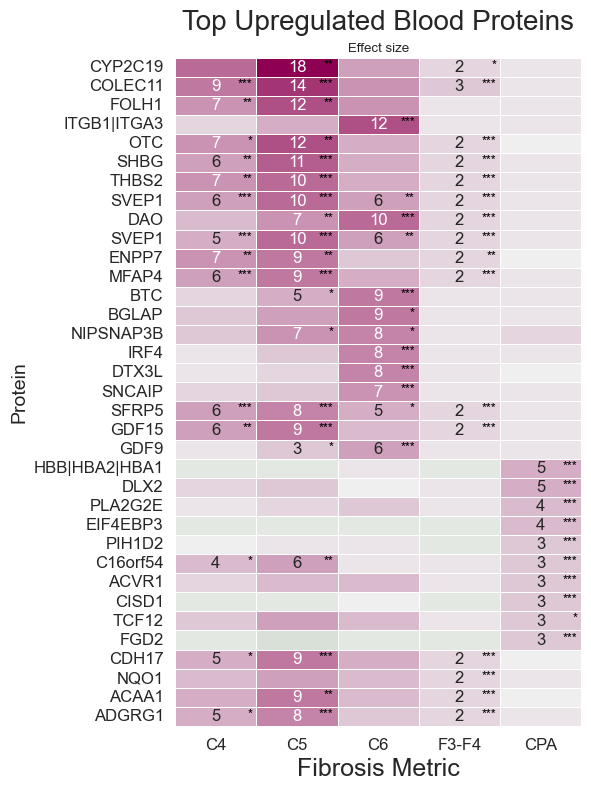

In [26]:
ut.plot_top_genes_heatmap(
    summary_table_upregulated,
    ['C4 Effect Size','C5 Effect Size','C6 Effect Size','F3-F4 Effect Size','CPA Effect Size'],
    ['C4 adj.P.Val','C5 adj.P.Val','C6 adj.P.Val','F3-F4 adj.P.Val','CPA adj.P.Val'],
    output_path=f'{output_dir}/plots/top_{top_n}_upregulated_proteins_heatmap.png',
    title="Top Upregulated Blood Proteins",
    cmap=make_piyg_with_grey_r(),
    #bold_genes=["COL10A1"],
    #rename_genes={"novel transcript": "KRT222"}
    )

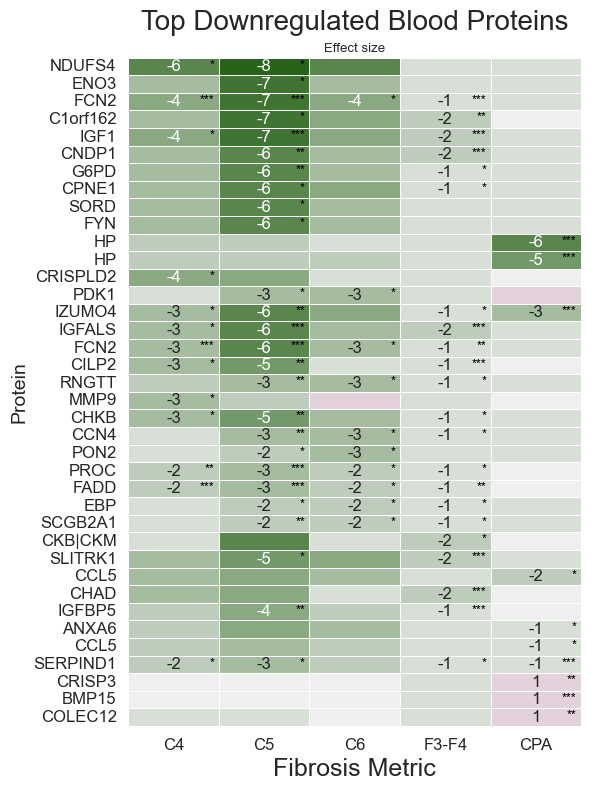

In [27]:
ut.plot_top_genes_heatmap(
    summary_table_downregulated,
    ['C4 Effect Size','C5 Effect Size','C6 Effect Size','F3-F4 Effect Size','CPA Effect Size'],
    ['C4 adj.P.Val','C5 adj.P.Val','C6 adj.P.Val','F3-F4 adj.P.Val','CPA adj.P.Val'],
    output_path=f'{output_dir}/plots/top_{top_n}_downregulated_proteins_heatmap.png',
    title="Top Downregulated Blood Proteins",
    cmap=make_piyg_with_grey_r(),
    #bold_genes=["COL10A1"],
    #rename_genes=gene_name_mapping
    )

# Top molecule concordance (Jaccard index)

In [28]:
jaccard_up_df = ut.jaccard_top_effect_genes(significant_proteins, 'C5', ['C4', 'C6', 'CPA', 'F3-F4'], 100, "up")
jaccard_up_df

,Jaccard_index,intersection,union
C4,0.562500,72,128
F3-F4,0.526718,69,131
C6,0.073333,11,150
CPA,0.006452,1,155


In [29]:
jaccard_up_df = ut.jaccard_top_effect_genes(significant_proteins, 'C5', ['C4', 'C6', 'CPA', 'F3-F4'], 100, "down")
jaccard_up_df

,Jaccard_index,intersection,union
F3-F4,0.324503,49,151
C4,0.244275,32,131
C6,0.067308,7,104
CPA,0.009434,1,106
